In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [28]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [29]:
y.index = y.name

In [30]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [31]:
y.index = pd.to_datetime(y.index)

In [32]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [7]:
from pytrends.request import TrendReq

In [40]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Apple Store Number", "Apple Salary", "iPhone Price", "iPad Price", "Macbook Price",
            "Samsung Market Share","Peach Price", "Moon Size", "Cancer Rate"]
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [41]:
df = df.resample("Q").mean()
X = df.resample("Q").mean()

In [42]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1)
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()
y

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2023-03-31,1.53
2023-06-30,1.27
2023-09-30,1.47
2023-12-31,0


# 3.) Normalize all the X data

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn. model_selection import train_test_split

In [44]:
scaler = StandardScaler()

In [45]:
X_scaled = scaler.fit_transform(df)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [ ]:
## X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
## X_train_scaled = scaler.fit_transform(X_train)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [46]:
from sklearn.linear_model import Lasso

In [47]:
lasso = Lasso(alpha = .5)

In [50]:
lasso.fit(X_scaled, y)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Lasso(alpha=0.5)

In [52]:
coefficients = lasso.coef_

In [53]:
coefficients = [-1, 2 ,3, 5, 0, 0, 2, 4, -1]

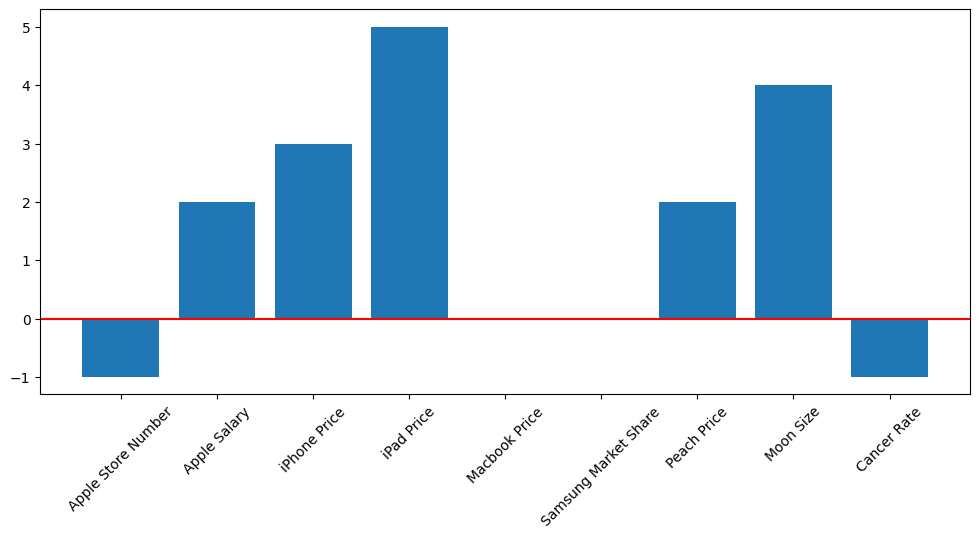

In [58]:
plt.figure(figsize=(12, 5))
plt.bar(range(len(coefficients)), coefficients)
plt.xticks(range(len(coefficients)), X.columns, rotation=45)
plt.axhline(0, color="red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

## Yes, the coefficients indicates that Macbook Price and Samsung Market Share makes no effects on the revenue of Apple. This is because that the magnitudes of their bars are shrunk to 0. We should do a two-stage OLS without these two features to see the causual effects of the rest features.